# Model 3: Including Free Text

In the final model we'll build in this post we'll demonstrate how to include free text as a feature alongside the numeric and embedding features we used above.

The key idea here is to include a component in our model that takes a sequence of variable length (in this case an LSTM) and projects that sequence into a feature space with fixed dimmension. Then we'll concatenate this feature representation alongside the numeric features just as we did with the embeddings above. Note that this approach could also work for other non-tabular data sources such as image or video or time series.

Note that to keep the implementation in this post simple we're actually going to restrict the wikipedia descriptions to 250 characters, and if the description has fewer characters we will just pad the sequence to get the full 250. This has the effect of treating the free text data as having a fixed, and not variable, length as promised. However the code below can be easily adjusted to accomodate this by using a batch generator and padding the batches rather than the entire data set once. Again the graphical representation of the model below is helpful.

Out of curiosity we'll get a rough count of about how many words are in each wiki page.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('mercari-price-suggestion-challenge/train.tsv', sep='\t')
df_train, df_test = train_test_split(df)

In [2]:
df_train.shape, df_test.shape

((1111901, 8), (370634, 8))

In [3]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
89592,89592,VS Angel make up bag,2,Women/Women's Handbags/Cosmetic Bags,Victoria's Secret,9.0,0,No description yet
207462,207462,Kylie lip kit -- Kristen and Leo,2,Beauty/Makeup/Lips,NaN,37.0,0,No box. Only used to swatch one time. Pretty m...
1406312,1406312,(40) 10x13 color heart polymailer,1,Other/Office supplies/Shipping Supplies,NaN,10.0,1,- 40 pieces of 10x13 color heart poly mailer *...
289434,289434,Lisa Frank Dream Writers Planner,3,Other/Office supplies/Organization,NaN,10.0,0,"Really cute, good shape, minor creases. Full s..."
1388216,1388216,Black Full Bodysuit Sexy Lace Dress,1,Women/Underwear/Other,NaN,23.0,1,Brand new black lace bodysuit one piece. Beaut...


In [4]:
df_train.describe(include='all')

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
count,1.111901e+06,1111901,1.111901e+06,1107170,637283,1.111901e+06,1.111901e+06,1111899
unique,NaN,936387,NaN,1263,4438,NaN,NaN,967919
top,NaN,Bundle,NaN,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,NaN,NaN,No description yet
freq,NaN,1664,NaN,45284,40608,NaN,NaN,61749
mean,7.408820e+05,NaN,1.907878e+00,NaN,NaN,2.676088e+01,4.471549e-01,NaN
std,4.279336e+05,NaN,9.032165e-01,NaN,NaN,3.863833e+01,4.971998e-01,NaN
min,0.000000e+00,NaN,1.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,NaN
25%,3.700790e+05,NaN,1.000000e+00,NaN,NaN,1.000000e+01,0.000000e+00,NaN
50%,7.406720e+05,NaN,2.000000e+00,NaN,NaN,1.700000e+01,0.000000e+00,NaN
75%,1.111400e+06,NaN,3.000000e+00,NaN,NaN,2.900000e+01,1.000000e+00,NaN


In [5]:
import keras

def make_Xy(df, tokenizer=None):
    category_ids = {v: i for i, v in enumerate(df.category_name.unique())}
    brand_ids = {v: i for i, v in enumerate(df.brand_name.unique())}
    df['category_id'] = df.category_name.map(category_ids)
    df['brand_id'] = df.brand_name.map(brand_ids)
    df['item_condition_id'] -= 1

    df['text'] = df.name + ' ' + df.item_description.str.replace('No description yet', '')
    df['text'] = df.text.astype(str)
    if tokenizer is None:
        tokenizer = keras.preprocessing.text.Tokenizer(num_words=2000)
        tokenizer.fit_on_texts(df_train.text)
    tokens = tokenizer.texts_to_sequences(df.text)
    tokens = keras.preprocessing.sequence.pad_sequences(tokens, maxlen=50)
    X = {
        'category_input': df.category_id,
        'brand_input': df.brand_id,
        'item_condition_input': df.item_condition_id,
        'text_input': tokens}
    y = df.price
    return X, y, tokenizer

X_train, y_train, tokenizer = make_Xy(df_train)
X_test, y_test, _ = make_Xy(df_test, tokenizer)

Using TensorFlow backend.
/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [6]:
df_train.text.str.count(' ').describe()

count    1.111901e+06
mean     2.899076e+01
std      3.088700e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.900000e+01
75%      3.500000e+01
max      2.460000e+02
Name: text, dtype: float64

In [7]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_id,brand_id,text
89592,89592,VS Angel make up bag,1,Women/Women's Handbags/Cosmetic Bags,Victoria's Secret,9.0,0,No description yet,0,0,VS Angel make up bag
207462,207462,Kylie lip kit -- Kristen and Leo,1,Beauty/Makeup/Lips,NaN,37.0,0,No box. Only used to swatch one time. Pretty m...,1,1,Kylie lip kit -- Kristen and Leo No box. Only ...
1406312,1406312,(40) 10x13 color heart polymailer,0,Other/Office supplies/Shipping Supplies,NaN,10.0,1,- 40 pieces of 10x13 color heart poly mailer *...,2,1,(40) 10x13 color heart polymailer - 40 pieces ...
289434,289434,Lisa Frank Dream Writers Planner,2,Other/Office supplies/Organization,NaN,10.0,0,"Really cute, good shape, minor creases. Full s...",3,1,"Lisa Frank Dream Writers Planner Really cute, ..."
1388216,1388216,Black Full Bodysuit Sexy Lace Dress,0,Women/Underwear/Other,NaN,23.0,1,Brand new black lace bodysuit one piece. Beaut...,4,1,Black Full Bodysuit Sexy Lace Dress Brand new ...


In [8]:
category_input = keras.layers.Input(shape=(1,), name='category_input')
brand_input = keras.layers.Input(shape=(1,), name='brand_input')
item_condition_input = keras.layers.Input(shape=(1,), name='item_condition_input')
text_input = keras.layers.Input(shape=(None,), name='text_input')
inputs = [category_input, brand_input, item_condition_input, text_input]

# categorical feature embeddings
category_embedding = keras.layers.Embedding(
    input_dim=df_train.category_id.nunique()+1,
    output_dim=15, input_length=1)(category_input)

brand_embedding = keras.layers.Embedding(
    input_dim=df_train.brand_id.nunique()+1,
    output_dim=15, input_length=1)(brand_input)

item_condition_embedding = keras.layers.Embedding(
    input_dim=df_train.item_condition_id.nunique()+1,
    output_dim=3, input_length=1)(item_condition_input)

embedding_tensors = [category_embedding, brand_embedding, item_condition_embedding]
x_embeddings = keras.layers.Concatenate()([
    keras.layers.Flatten()(embedding) for embedding in embedding_tensors
])


# LSTM input
import keras.backend as K
Sum = keras.layers.Lambda(lambda x: K.sum(x, axis=1))
def Attention(X):
    # https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf
    W = keras.layers.Dense(K.int_shape(X)[-1], activation='tanh')
    u = W(X)
    u_w = keras.layers.Dense(1, activation='linear')
    attention = keras.layers.Softmax(1)(u_w(u))
    X_attended = keras.layers.Multiply()([X, attention])
    return Sum(X_attended), attention

text_embeddings = keras.layers.Embedding(
    input_dim=2000, output_dim=35, input_length=None)(text_input)
lstm_output = keras.layers.LSTM(20, return_sequences=True)(text_embeddings)
x_text, attention = Attention(lstm_output)


x = keras.layers.Concatenate()([x_embeddings, x_text])
x = keras.layers.Dense(75, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(75, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1, activation='relu')(x)

model = keras.models.Model(inputs=inputs, outputs=x)

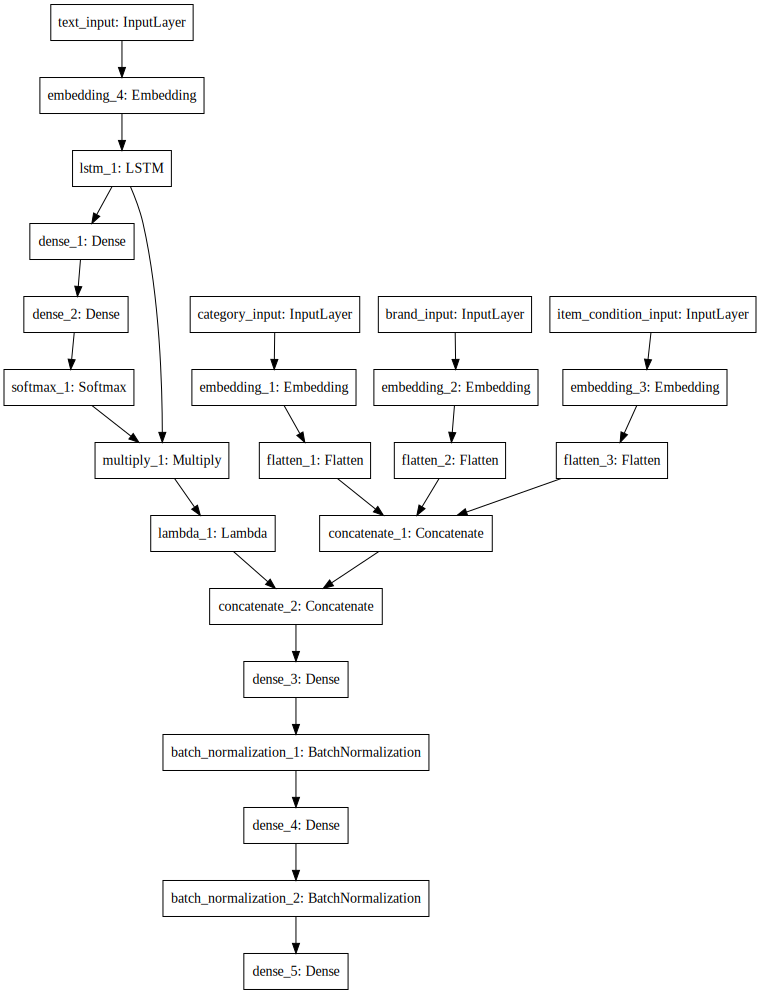

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [10]:
model.compile(loss='mse', optimizer='adam')

In [11]:
model.fit(
    X_train, y_train,
    epochs=25,
    validation_data=(X_test, y_test),
    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2), keras.callbacks.EarlyStopping(patience=3)]
)

Train on 1111901 samples, validate on 370634 samples
Epoch 1/25
  82432/1111901 [=>............................] - ETA: 22:54 - loss: 1158.7958

KeyboardInterrupt: 

In [ ]:
attention_model = keras.models.Model(inputs=descr_input, outputs=attention)
counties, county_descriptions = df[['county', 'county_description']].drop_duplicates().T.values

# process descriptions through the tokenizer
tokens = [s[:250] for s in tokenizer.texts_to_sequences(county_descriptions)]
county_descriptions = [t.split(' ') for t in tokenizer.sequences_to_texts(tokens)]

attention_scores = attention_model.predict(keras.preprocessing.sequence.pad_sequences(tokens, maxlen=250))
# resize the scores to eliminate redundant axis
attention_scores = descr_attention.reshape(descr_attention.shape[:2])

In [ ]:
zipped = zip(counties, descr_texts, attention_scores)
word_importances = [
    (county, tuple([(w, i) for w, i in zip(description, description_importances)]))
    for county, description, description_importances in zipped
]

In [ ]:
word_importances

In [ ]:
county_word_importances = {
    county: sorted(set(importances), key=lambda x: x[-1], reverse=True)[:10]
     for county, importances in word_importances
}
county_word_importances

In [ ]:
county_word_importances['Del Norte County']